In [19]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
data_path = '/content/drive/MyDrive/task2itsolera (1)/'



In [21]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

vibration_data = np.load(data_path + 'tabular_features.npy')
thermal_data = np.load(data_path + 'thermal_images.npy')
geo_maps_data = np.load(data_path + 'geo_maps.npy')

labels_df = pd.read_csv(data_path + 'synchronized_dataset.csv')
print(labels_df.columns.tolist())




['filename', 'sandstone_%', 'granite_%', 'shale_%', 'fault_density', 'support_coverage', 'event_index', 'geo_map_path', 'thermal_image_path', 'seismic', 'seismoacoustic', 'shift', 'genergy', 'gpuls', 'gdenergy', 'gdpuls', 'hazard', 'nbumps', 'nbumps2', 'nbumps3', 'nbumps4', 'nbumps5', 'nbumps6', 'nbumps7', 'nbumps89', 'energy', 'maxenergy', 'class', 'event_id', 'tangential_stress_MPa', 'compressive_strength_MPa', 'tensile_strength_MPa', 'brittleness_ratio', 'elastic_strain_energy_kJ', 'rockburst_intensity']


In [22]:
labels = labels_df['rockburst_intensity'].values  # Use the correct column name

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print("Shapes:")
print("Vibration data:", vibration_data.shape)
print("Thermal data:", thermal_data.shape)
print("Geo maps data:", geo_maps_data.shape)
print("Labels shape:", labels_encoded.shape)
print("Classes:", le.classes_)

Shapes:
Vibration data: (100, 38)
Thermal data: (100, 224, 224, 3)
Geo maps data: (100, 32, 32, 5)
Labels shape: (100,)
Classes: ['I' 'II' 'III' 'IV']


In [23]:
!pip install tensorflow

In [24]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Bidirectional, GRU,
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    LayerNormalization, MultiHeadAttention, Concatenate, Lambda
)

# Vibration backbone
def build_vibration_model(input_shape):
    inp = Input(shape=input_shape)
    x = Conv1D(64, kernel_size=3, activation='relu', padding='same')(inp)
    x = MaxPooling1D(2)(x)
    x = Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(GRU(64, return_sequences=False))(x)
    model = Model(inp, x, name='vibration_model')
    return model

# Thermal backbone
def build_thermal_model(input_shape):
    inp = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    model = Model(inp, x, name='thermal_model')
    return model

# Geo backbone
def build_geo_model(input_shape):
    inp = Input(shape=input_shape)
    x = Conv2D(32, 3, activation='relu', padding='same')(inp)
    x = MaxPooling2D(2)(x)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Conv2D(128, 3, activation='relu', padding='same')(x)
    x = MaxPooling2D(2)(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    model = Model(inp, x, name='geo_model')
    return model

# Cross-attention fusion layer
class CrossAttentionFusion(layers.Layer):
    def __init__(self, embed_dim, num_heads=4):
        super(CrossAttentionFusion, self).__init__()
        self.mha = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.layernorm = LayerNormalization(epsilon=1e-6)
        self.dropout = Dropout(0.2)

    def call(self, query, value, training=False):
        attn_output = self.mha(query=query, value=value, key=value)
        attn_output = self.dropout(attn_output, training=training)
        return self.layernorm(query + attn_output)

# Build full multi-modal model
def build_multi_modal_model(vib_model, thermal_model, geo_model, vib_shape, thermal_shape, geo_shape, num_classes):
    vib_inp = Input(shape=vib_shape, name='vibration_input')
    thermal_inp = Input(shape=thermal_shape, name='thermal_input')
    geo_inp = Input(shape=geo_shape, name='geo_input')

    vib_embed = vib_model(vib_inp)
    thermal_embed = thermal_model(thermal_inp)
    geo_embed = geo_model(geo_inp)

    vib_proj = Dense(128, activation='relu')(vib_embed)
    thermal_proj = Dense(128, activation='relu')(thermal_embed)
    geo_proj = Dense(128, activation='relu')(geo_embed)

    # Use Lambda layers for expand_dims and squeeze
    vib_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(vib_proj)
    thermal_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(thermal_proj)
    geo_exp = Lambda(lambda x: tf.expand_dims(x, axis=1))(geo_proj)

    cross_attn = CrossAttentionFusion(embed_dim=128, num_heads=4)

    vib_attn = cross_attn(vib_exp, thermal_exp)
    thermal_attn = cross_attn(thermal_exp, geo_exp)
    geo_attn = cross_attn(geo_exp, vib_exp)

    vib_attn = Lambda(lambda x: tf.squeeze(x, axis=1))(vib_attn)
    thermal_attn = Lambda(lambda x: tf.squeeze(x, axis=1))(thermal_attn)
    geo_attn = Lambda(lambda x: tf.squeeze(x, axis=1))(geo_attn)

    fused = Concatenate()([vib_attn, thermal_attn, geo_attn])

    x = Dropout(0.3)(fused)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(128, activation='relu')(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=[vib_inp, thermal_inp, geo_inp], outputs=output, name='MultiModalFusionNet')
    return model

# Example usage:

# Make sure vibration data is reshaped properly before passing:
# vibration_data shape: (samples, 38) → reshape to (samples, 38, 1)
vibration_data = vibration_data.reshape((vibration_data.shape[0], vibration_data.shape[1], 1))

num_classes = len(np.unique(labels_encoded))

vib_model = build_vibration_model(vibration_data.shape[1:])
thermal_model = build_thermal_model(thermal_data.shape[1:])
geo_model = build_geo_model(geo_maps_data.shape[1:])

model = build_multi_modal_model(
    vib_model, thermal_model, geo_model,
    vibration_data.shape[1:], thermal_data.shape[1:], geo_maps_data.shape[1:],
    num_classes
)

model.summary()


Model: "MultiModalFusionNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ vibration_input     │ (None, 38, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ thermal_input       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geo_input           │ (None, 32, 32, 5) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vibration_model     │ (None, 128)       │     99,456 │ vibration_input[… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ thermal_model       │ (None, 256)       │ 25,783,616 │ thermal_input[0]… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ geo_model           │ (None, 256)       │    618,368 │ geo_input[0][0]   │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_98 (Dense)    │ (None, 128)       │     16,512 │ vibration_model[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_99 (Dense)    │ (None, 128)       │     32,896 │ thermal_model[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_100 (Dense)   │ (None, 128)       │     32,896 │ geo_model[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_72 (Lambda)  │ (None, 1, 128)    │          0 │ dense_98[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_73 (Lambda)  │ (None, 1, 128)    │          0 │ dense_99[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_74 (Lambda)  │ (None, 1, 128)    │          0 │ dense_100[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cross_attention_fu… │ (None, 1, 128)    │    264,064 │ lambda_72[0][0],  │
│ (CrossAttentionFus… │                   │            │ lambda_73[0][0],  │
│                     │                   │            │ lambda_73[0][0],  │
│                     │                   │            │ lambda_74[0][0],  │
│                     │                   │            │ lambda_74[0][0],  │
│                     │                   │            │ lambda_72[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_75 (Lambda)  │ (None, 128)       │          0 │ cross_attention_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_76 (Lambda)  │ (None, 128)       │          0 │ cross_attention_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_77 (Lambda)  │ (None, 128)       │          0 │ cross_attention_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_12      │ (None, 384)       │          0 │ lambda_75[0][0],  │
│ (Concatenate)       │                   │            │ lambda_76[0][0],  │
│                     │                   │            │ lambda_77[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_50          │ (None, 384)       │          0 │ concatenate_12[0… │
│ (Dropout)           │                   │            │                 

 Total params: 26,979,780 (102.92 MB)

 Trainable params: 26,979,780 (102.92 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
!pip install imbalanced-learn

In [27]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, balanced_accuracy_score, f1_score

# Augmentation functions
def augment_vibration(vib):
    vib = tf.cast(vib, tf.float32)
    noise = tf.random.normal(shape=tf.shape(vib), mean=0.0, stddev=0.02)
    vib = vib + noise
    scale = tf.random.uniform([], 0.9, 1.1)
    vib = vib * scale
    return vib

def augment_thermal(thermal):
    thermal = tf.image.random_flip_left_right(thermal)
    return thermal

def augment_geo(geo):
    geo = tf.image.random_flip_up_down(geo)
    return geo

# Cosine annealing scheduler with warmup
def cosine_annealing_with_warmup(epoch, total_epochs=50, warmup_epochs=5, initial_lr=1e-4):
    if epoch < warmup_epochs:
        return initial_lr * (epoch + 1) / warmup_epochs
    progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
    return initial_lr * 0.5 * (1 + np.cos(np.pi * progress))

# Stratified K-Fold setup
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Store all fold results
history_all = []
all_test_labels = []
all_predictions = []

fold_no = 1
for train_idx, val_idx in skf.split(vibration_data, labels_encoded):
    print(f"\n--- Training fold {fold_no}/{n_splits} ---")

    # Split
    X_train_vib, X_val_vib = vibration_data[train_idx], vibration_data[val_idx]
    X_train_thermal, X_val_thermal = thermal_data[train_idx], thermal_data[val_idx]
    X_train_geo, X_val_geo = geo_maps_data[train_idx], geo_maps_data[val_idx]
    y_train, y_val = labels_encoded[train_idx], labels_encoded[val_idx]

    # Oversampling
    ros = RandomOverSampler(random_state=42)

    def flatten_and_stack(vib, therm, geo):
        return np.hstack([
            vib.reshape(vib.shape[0], -1),
            therm.reshape(therm.shape[0], -1),
            geo.reshape(geo.shape[0], -1)
        ])

    def reshape_split(flat_data, vib_shape, therm_shape, geo_shape):
        vib_size = np.prod(vib_shape)
        therm_size = np.prod(therm_shape)
        vib_flat = flat_data[:, :vib_size]
        therm_flat = flat_data[:, vib_size:vib_size+therm_size]
        geo_flat = flat_data[:, vib_size+therm_size:]
        return (vib_flat.reshape((-1, *vib_shape)),
                therm_flat.reshape((-1, *therm_shape)),
                geo_flat.reshape((-1, *geo_shape)))

    vib_shape, therm_shape, geo_shape = vibration_data.shape[1:], thermal_data.shape[1:], geo_maps_data.shape[1:]
    X_train_flat = flatten_and_stack(X_train_vib, X_train_thermal, X_train_geo)
    X_train_resampled, y_train_resampled = ros.fit_resample(X_train_flat, y_train)
    X_train_vib, X_train_thermal, X_train_geo = reshape_split(X_train_resampled, vib_shape, therm_shape, geo_shape)
    y_train = y_train_resampled

    # Class weights
    classes = np.unique(y_train)
    class_weights_raw = compute_class_weight('balanced', classes=classes, y=y_train)
    class_weights = {cls: weight for cls, weight in zip(classes, class_weights_raw)}
    class_weights_tensor = tf.constant([class_weights[i] for i in range(num_classes)], dtype=tf.float32)

    # One-hot encoding
    y_train_oh = to_categorical(y_train, num_classes)
    y_val_oh = to_categorical(y_val, num_classes)

    # Data pipeline
    def augment_data(vib, therm, geo, label):
        return augment_vibration(vib), augment_thermal(therm), augment_geo(geo), label

    train_ds = tf.data.Dataset.from_tensor_slices((X_train_vib, X_train_thermal, X_train_geo, y_train_oh))
    train_ds = train_ds.map(augment_data, num_parallel_calls=tf.data.AUTOTUNE)
    train_ds = train_ds.map(lambda v, t, g, l: ((v, t, g), l))
    train_ds = train_ds.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

    val_ds = tf.data.Dataset.from_tensor_slices(((X_val_vib, X_val_thermal, X_val_geo), y_val_oh))
    val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

    # Weighted categorical crossentropy with label smoothing
    def weighted_categorical_crossentropy_label_smooth(y_true, y_pred, smooth_factor=0.05):
        y_true = y_true * (1 - smooth_factor) + (smooth_factor / num_classes)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1 - 1e-7)
        unweighted_loss = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
        weights = tf.reduce_sum(y_true * class_weights_tensor, axis=-1)
        return tf.reduce_mean(unweighted_loss * weights)

    # Build models (you must define these functions)
    vib_model = build_vibration_model(vib_shape)
    thermal_model = build_thermal_model(therm_shape)
    geo_model = build_geo_model(geo_shape)

    model = build_multi_modal_model(vib_model, thermal_model, geo_model, vib_shape, therm_shape, geo_shape, num_classes)

    # Compile
    model.compile(
        optimizer=AdamW(learning_rate=1e-4, weight_decay=1e-4),
        loss=weighted_categorical_crossentropy_label_smooth,
        metrics=['accuracy']
    )

    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        LearningRateScheduler(lambda epoch, lr: cosine_annealing_with_warmup(epoch, total_epochs=50, warmup_epochs=5, initial_lr=1e-4))
    ]

    # Train
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=50,
        callbacks=callbacks,
        verbose=2
    )

    history_all.append(history.history)

    # Predict
    y_val_pred_probs = model.predict(val_ds)
    y_val_pred = np.argmax(y_val_pred_probs, axis=1)

    all_test_labels.extend(y_val)
    all_predictions.extend(y_val_pred)

    print(f"Fold {fold_no} Balanced Accuracy: {balanced_accuracy_score(y_val, y_val_pred):.4f}")
    print("Classification Report:\n", classification_report(y_val, y_val_pred, target_names=[f"Class {i}" for i in range(num_classes)]))
    print(f"Val Loss: {min(history.history['val_loss']):.4f} | Val Accuracy: {max(history.history['val_accuracy']):.4f}")

    fold_no += 1

# Final metrics
print("\n=== Overall Results ===")
print(classification_report(all_test_labels, all_predictions, target_names=[f"Class {i}" for i in range(num_classes)]))
print(f"Overall Balanced Accuracy: {balanced_accuracy_score(all_test_labels, all_predictions):.4f}")
print(f"Overall Macro F1 Score: {f1_score(all_test_labels, all_predictions, average='macro'):.4f}")



--- Training fold 1/5 ---
Epoch 1/50
5/5 - 33s - 7s/step - accuracy: 0.1970 - loss: 1.7280 - val_accuracy: 0.2000 - val_loss: 1.5189 - learning_rate: 2.0000e-05
Epoch 2/50
5/5 - 20s - 4s/step - accuracy: 0.2273 - loss: 1.6503 - val_accuracy: 0.1500 - val_loss: 1.4792 - learning_rate: 4.0000e-05
Epoch 3/50
5/5 - 19s - 4s/step - accuracy: 0.2576 - loss: 1.5668 - val_accuracy: 0.1000 - val_loss: 1.4590 - learning_rate: 6.0000e-05
Epoch 4/50
5/5 - 19s - 4s/step - accuracy: 0.3333 - loss: 1.4118 - val_accuracy: 0.1000 - val_loss: 1.5761 - learning_rate: 8.0000e-05
Epoch 5/50
5/5 - 21s - 4s/step - accuracy: 0.2652 - loss: 1.5691 - val_accuracy: 0.1000 - val_loss: 1.8039 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 - 20s - 4s/step - accuracy: 0.2727 - loss: 1.5268 - val_accuracy: 0.1000 - val_loss: 1.5105 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 - 19s - 4s/step - accuracy: 0.2273 - loss: 1.5082 - val_accuracy: 0.4500 - val_loss: 1.2521 - learning_rate: 9.9878e-05
Epoch 8/50
5/5 - 20s - 4s/st

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
5/5 - 33s - 7s/step - accuracy: 0.1591 - loss: 1.6988 - val_accuracy: 0.1000 - val_loss: 1.7148 - learning_rate: 2.0000e-05
Epoch 2/50
5/5 - 20s - 4s/step - accuracy: 0.2955 - loss: 1.5808 - val_accuracy: 0.0500 - val_loss: 1.6805 - learning_rate: 4.0000e-05
Epoch 3/50
5/5 - 19s - 4s/step - accuracy: 0.2879 - loss: 1.5771 - val_accuracy: 0.3000 - val_loss: 1.3998 - learning_rate: 6.0000e-05
Epoch 4/50
5/5 - 21s - 4s/step - accuracy: 0.2803 - loss: 1.5572 - val_accuracy: 0.1000 - val_loss: 1.4045 - learning_rate: 8.0000e-05
Epoch 5/50
5/5 - 20s - 4s/step - accuracy: 0.2652 - loss: 1.5462 - val_accuracy: 0.0500 - val_loss: 1.5961 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 - 19s - 4s/step - accuracy: 0.3182 - loss: 1.4500 - val_accuracy: 0.0500 - val_loss: 1.5112 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 - 21s - 4s/step - accuracy: 0.2424 - loss: 1.5266 - val_accuracy: 0.0500 - val_loss: 1.5172 - learning_rate: 9.9878e-05
Epoch 8/50
5/5 - 20s - 4s/step - accuracy: 0.3030 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
5/5 - 35s - 7s/step - accuracy: 0.1765 - loss: 1.7230 - val_accuracy: 0.4000 - val_loss: 1.3734 - learning_rate: 2.0000e-05
Epoch 2/50
5/5 - 23s - 5s/step - accuracy: 0.2279 - loss: 1.5951 - val_accuracy: 0.2500 - val_loss: 1.5213 - learning_rate: 4.0000e-05
Epoch 3/50
5/5 - 19s - 4s/step - accuracy: 0.2647 - loss: 1.5783 - val_accuracy: 0.1500 - val_loss: 1.4419 - learning_rate: 6.0000e-05
Epoch 4/50
5/5 - 21s - 4s/step - accuracy: 0.2206 - loss: 1.5524 - val_accuracy: 0.4500 - val_loss: 1.2635 - learning_rate: 8.0000e-05
Epoch 5/50
5/5 - 21s - 4s/step - accuracy: 0.2941 - loss: 1.5256 - val_accuracy: 0.6000 - val_loss: 1.2950 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 - 19s - 4s/step - accuracy: 0.2500 - loss: 1.4323 - val_accuracy: 0.3500 - val_loss: 1.3867 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 - 21s - 4s/step - accuracy: 0.3088 - loss: 1.4403 - val_accuracy: 0.1000 - val_loss: 1.4308 - learning_rate: 9.9878e-05
Epoch 8/50
5/5 - 20s - 4s/step - accuracy: 0.2868 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
5/5 - 33s - 7s/step - accuracy: 0.2868 - loss: 1.5420 - val_accuracy: 0.1500 - val_loss: 1.4151 - learning_rate: 2.0000e-05
Epoch 2/50
5/5 - 20s - 4s/step - accuracy: 0.3162 - loss: 1.5515 - val_accuracy: 0.1000 - val_loss: 1.5015 - learning_rate: 4.0000e-05
Epoch 3/50
5/5 - 19s - 4s/step - accuracy: 0.2500 - loss: 1.5182 - val_accuracy: 0.1500 - val_loss: 1.4648 - learning_rate: 6.0000e-05
Epoch 4/50
5/5 - 21s - 4s/step - accuracy: 0.2794 - loss: 1.4275 - val_accuracy: 0.1500 - val_loss: 1.3601 - learning_rate: 8.0000e-05
Epoch 5/50
5/5 - 20s - 4s/step - accuracy: 0.2941 - loss: 1.4972 - val_accuracy: 0.4000 - val_loss: 1.3547 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 - 19s - 4s/step - accuracy: 0.2794 - loss: 1.4968 - val_accuracy: 0.3500 - val_loss: 1.4675 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 - 20s - 4s/step - accuracy: 0.2941 - loss: 1.4425 - val_accuracy: 0.1500 - val_loss: 1.4905 - learning_rate: 9.9878e-05
Epoch 8/50
5/5 - 19s - 4s/step - accuracy: 0.3676 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch 1/50
5/5 - 33s - 7s/step - accuracy: 0.2426 - loss: 1.6770 - val_accuracy: 0.1000 - val_loss: 1.6674 - learning_rate: 2.0000e-05
Epoch 2/50
5/5 - 40s - 8s/step - accuracy: 0.2353 - loss: 1.6017 - val_accuracy: 0.4000 - val_loss: 1.3909 - learning_rate: 4.0000e-05
Epoch 3/50
5/5 - 20s - 4s/step - accuracy: 0.2574 - loss: 1.6620 - val_accuracy: 0.1500 - val_loss: 1.4202 - learning_rate: 6.0000e-05
Epoch 4/50
5/5 - 19s - 4s/step - accuracy: 0.3015 - loss: 1.4318 - val_accuracy: 0.1000 - val_loss: 1.5979 - learning_rate: 8.0000e-05
Epoch 5/50
5/5 - 24s - 5s/step - accuracy: 0.2794 - loss: 1.4527 - val_accuracy: 0.1000 - val_loss: 1.5506 - learning_rate: 1.0000e-04
Epoch 6/50
5/5 - 38s - 8s/step - accuracy: 0.3162 - loss: 1.3929 - val_accuracy: 0.3500 - val_loss: 1.4362 - learning_rate: 1.0000e-04
Epoch 7/50
5/5 - 21s - 4s/step - accuracy: 0.3015 - loss: 1.4194 - val_accuracy: 0.2500 - val_loss: 1.3873 - learning_rate: 9.9878e-05
Epoch 8/50
5/5 - 19s - 4s/step - accuracy: 0.3015 - los

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


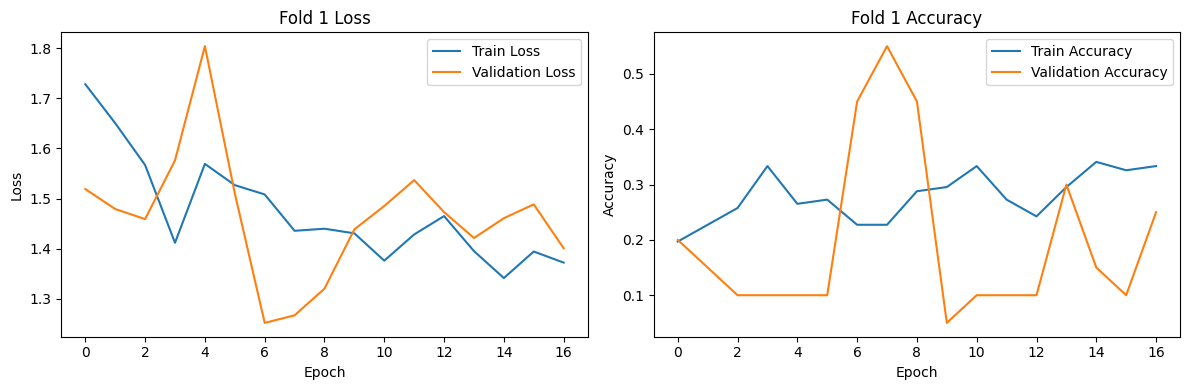

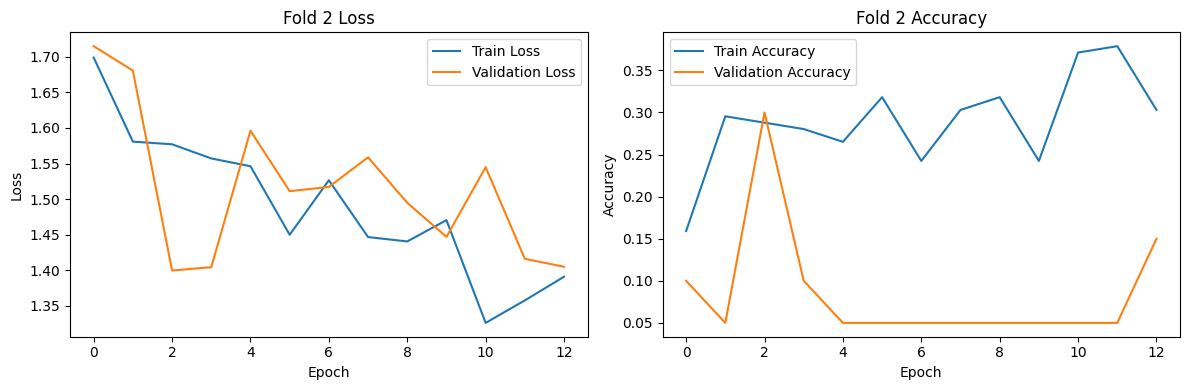

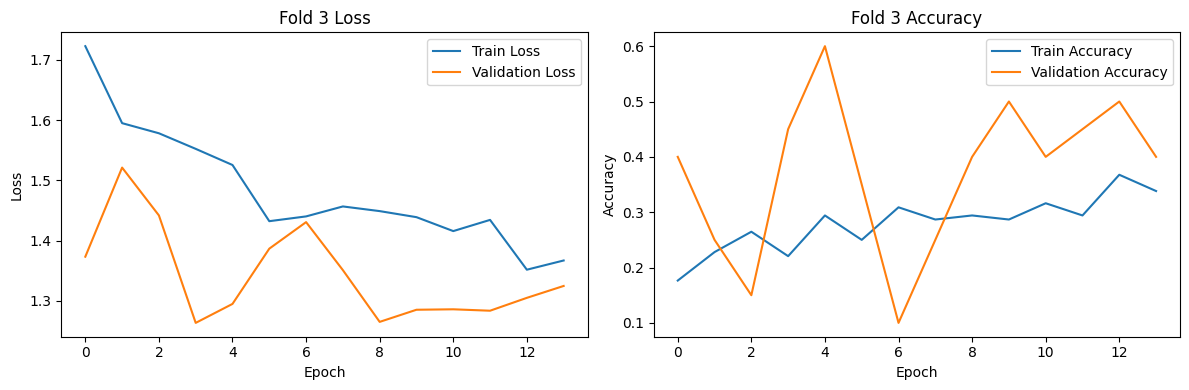

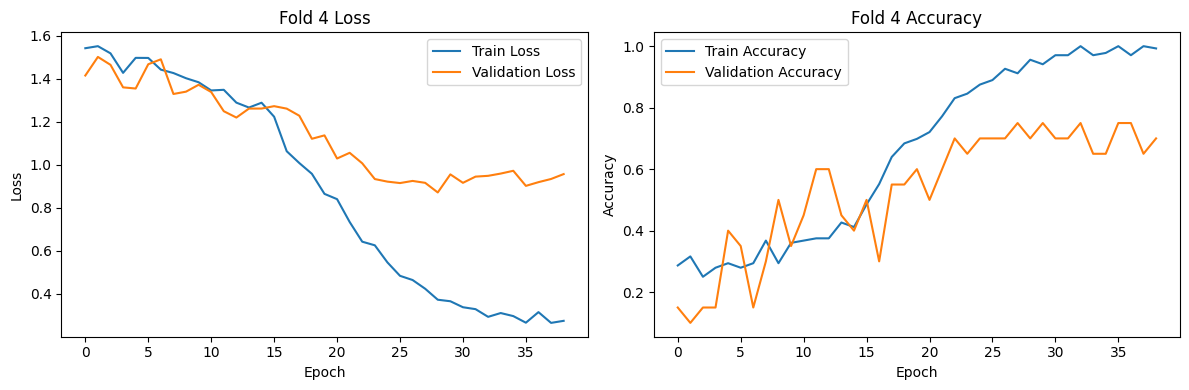

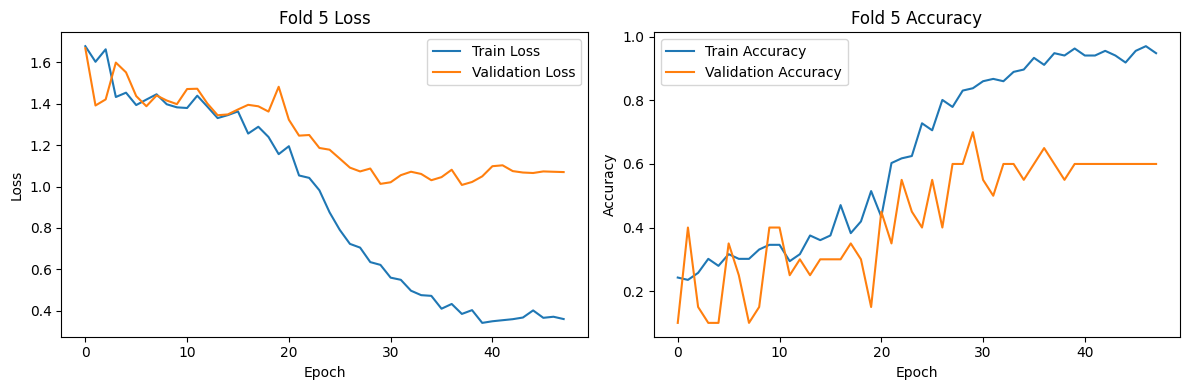

In [31]:
import matplotlib.pyplot as plt

# Plotting function
def plot_history(history, fold_no):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Fold {fold_no} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'Fold {fold_no} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each fold
for i, history in enumerate(history_all):
    plot_history(history, fold_no=i+1)